In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras import layers, models


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML Project/ratings_Electronics.csv')

In [ ]:
df.columns = ['reviewerID', 'product_id', 'rating', 'date']
df.head()

,reviewerID,product_id,rating,date
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [ ]:
df['date'] = pd.to_datetime(df['date'], unit='s')
df.sort_values(by=['reviewerID', 'date'], inplace=True)

In [ ]:
product_ids = df['product_id'].unique()
product_id_map = {product_id: i + 1 for i, product_id in enumerate(product_ids)}

In [ ]:
unique_products = df['product_id'].unique()
product_to_idx = {product: idx for idx, product in enumerate(unique_products)}
num_products = len(unique_products)
df['product_idx'] = df['product_id'].map(product_to_idx)

In [ ]:
# Split the data into train and test sets based on 'reviewerID' to avoid overlap
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['reviewerID']))
train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

In [ ]:
from tqdm import tqdm
import numpy as np

def create_interaction_array_with_dislike_flag(df1, k, dislike_threshold=3):
    """
    Creates a NumPy array of the first 3 product interactions for each user, a yratings array,
    and a dislike flag array.

    Args:
        df: DataFrame with 'reviewerID', 'product_idx', and 'rating' columns.
        k: Total number of products (length of the yratings array).
        dislike_threshold: Rating threshold to mark a product as disliked (default is 3).

    Returns:
        - interaction_matrix: NumPy array of shape (num_users, 3, 2), where each inner array represents
          a user's first 3 interactions as [[product_id, rating], ...]. Returns None if a user has fewer than 3 interactions.
        - yratings: NumPy array of shape (num_users, k), where each array represents ratings for k products,
          with zeros where the user has no interaction.
        - dislike_flags: NumPy array of shape (num_users, 3), where each entry is 1 if the corresponding product's
          rating is less than or equal to the dislike_threshold, 0 otherwise.
    """
    df = df1.copy()

    df['product_idx'] = df['product_idx'].astype(np.int16)
    df['rating'] = df['rating'].astype(np.int8)

    interaction_arrays = []
    yratings_list = []
    dislike_flags_list = []

    for user_id, user_df in tqdm(df.groupby('reviewerID'), desc="Processing users"):
        if len(user_df) >= 3:
            interactions = user_df[['product_idx', 'rating']].values[:3].astype(np.int16)

            yratings = np.zeros(k, dtype=np.int8)

            # Populate yratings with user's ratings at the corresponding product indices
            for idx, rating in zip(user_df['product_idx'], user_df['rating']):
                yratings[idx] = rating

            dislike_flags = np.zeros(3, dtype=np.int8)
            for i in range(1, 3):
                if user_df['rating'].iloc[i-1] <= dislike_threshold:
                    dislike_flags[i-1] = 1

            interaction_arrays.append(interactions)
            yratings_list.append(yratings)
            dislike_flags_list.append(dislike_flags)

    return (
        np.array(interaction_arrays, dtype=np.int16),
        np.array(yratings_list, dtype=np.int8),
        np.array(dislike_flags_list, dtype=np.int8),
    )


In [ ]:
k = len(product_ids)
interaction_matrix, yratings_array, dislike_flags_array = create_interaction_array_with_dislike_flag(train_df, k)

Processing users: 100%|██████████| 1964334/1964334 [03:58<00:00, 8245.40it/s]


In [ ]:
product_ids = interaction_matrix[:, :, 0]
ratings = interaction_matrix[:, :, 1]
dislike_flags = dislike_flags_array

In [ ]:
def masked_mse(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    mse = tf.square(tf.cast(y_true, tf.float32) - y_pred) * mask
    return tf.reduce_sum(mse) / tf.reduce_sum(mask)

def masked_mae(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    mae = tf.abs(tf.cast(y_true, tf.float32) - y_pred) * mask
    return tf.reduce_sum(mae) / tf.reduce_sum(mask)

def masked_rmse(y_true, y_pred):
    mse = masked_mse(y_true, y_pred)
    return tf.sqrt(mse)

In [ ]:
# arch

product_input = layers.Input(shape=(3,), name="product_input", dtype=tf.int32)
rating_input = layers.Input(shape=(3,), name="rating_input", dtype=tf.float32)
dislike_flag_input = layers.Input(shape=(3,), name="dislike_flag_input", dtype=tf.float32)

# Embedding layers
product_embedding = layers.Embedding(input_dim=len(product_ids), output_dim=50)(product_input)
rating_embedding = layers.Embedding(input_dim=6, output_dim=1)(rating_input)
dislike_flag_input_expanded = layers.Reshape((3, 1))(dislike_flag_input)

# Combine embeddings and flags
merged_input = layers.Concatenate(axis=-1)([product_embedding, rating_embedding, dislike_flag_input_expanded])

# RNN layer
rnn_output = layers.Bidirectional(layers.LSTM(64))(merged_input)

# Dense output for predicted ratings
dense_output = layers.Dense(k, activation='linear')(rnn_output)

model_lstm1 = models.Model(inputs=[product_input, rating_input, dislike_flag_input], outputs=dense_output)

model_lstm1.compile(optimizer='adam', loss=masked_mse, metrics=[masked_mae,masked_rmse])

model_lstm1.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ product_input             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rating_input (InputLayer) │ (None, 3)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dislike_flag_input        │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 3, 50)          │     10,150,250 │ product_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 3, 1)           │              6 │ rating_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 3, 1)           │              0 │ dislike_flag_input[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3, 52)          │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding_1[0][0],     │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128)            │         59,904 │ concatenate[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 7474)           │        964,146 │ bidirectional[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,174,306 (42.63 MB)

 Trainable params: 11,174,306 (42.63 MB)

 Non-trainable params: 0 (0.00 B)

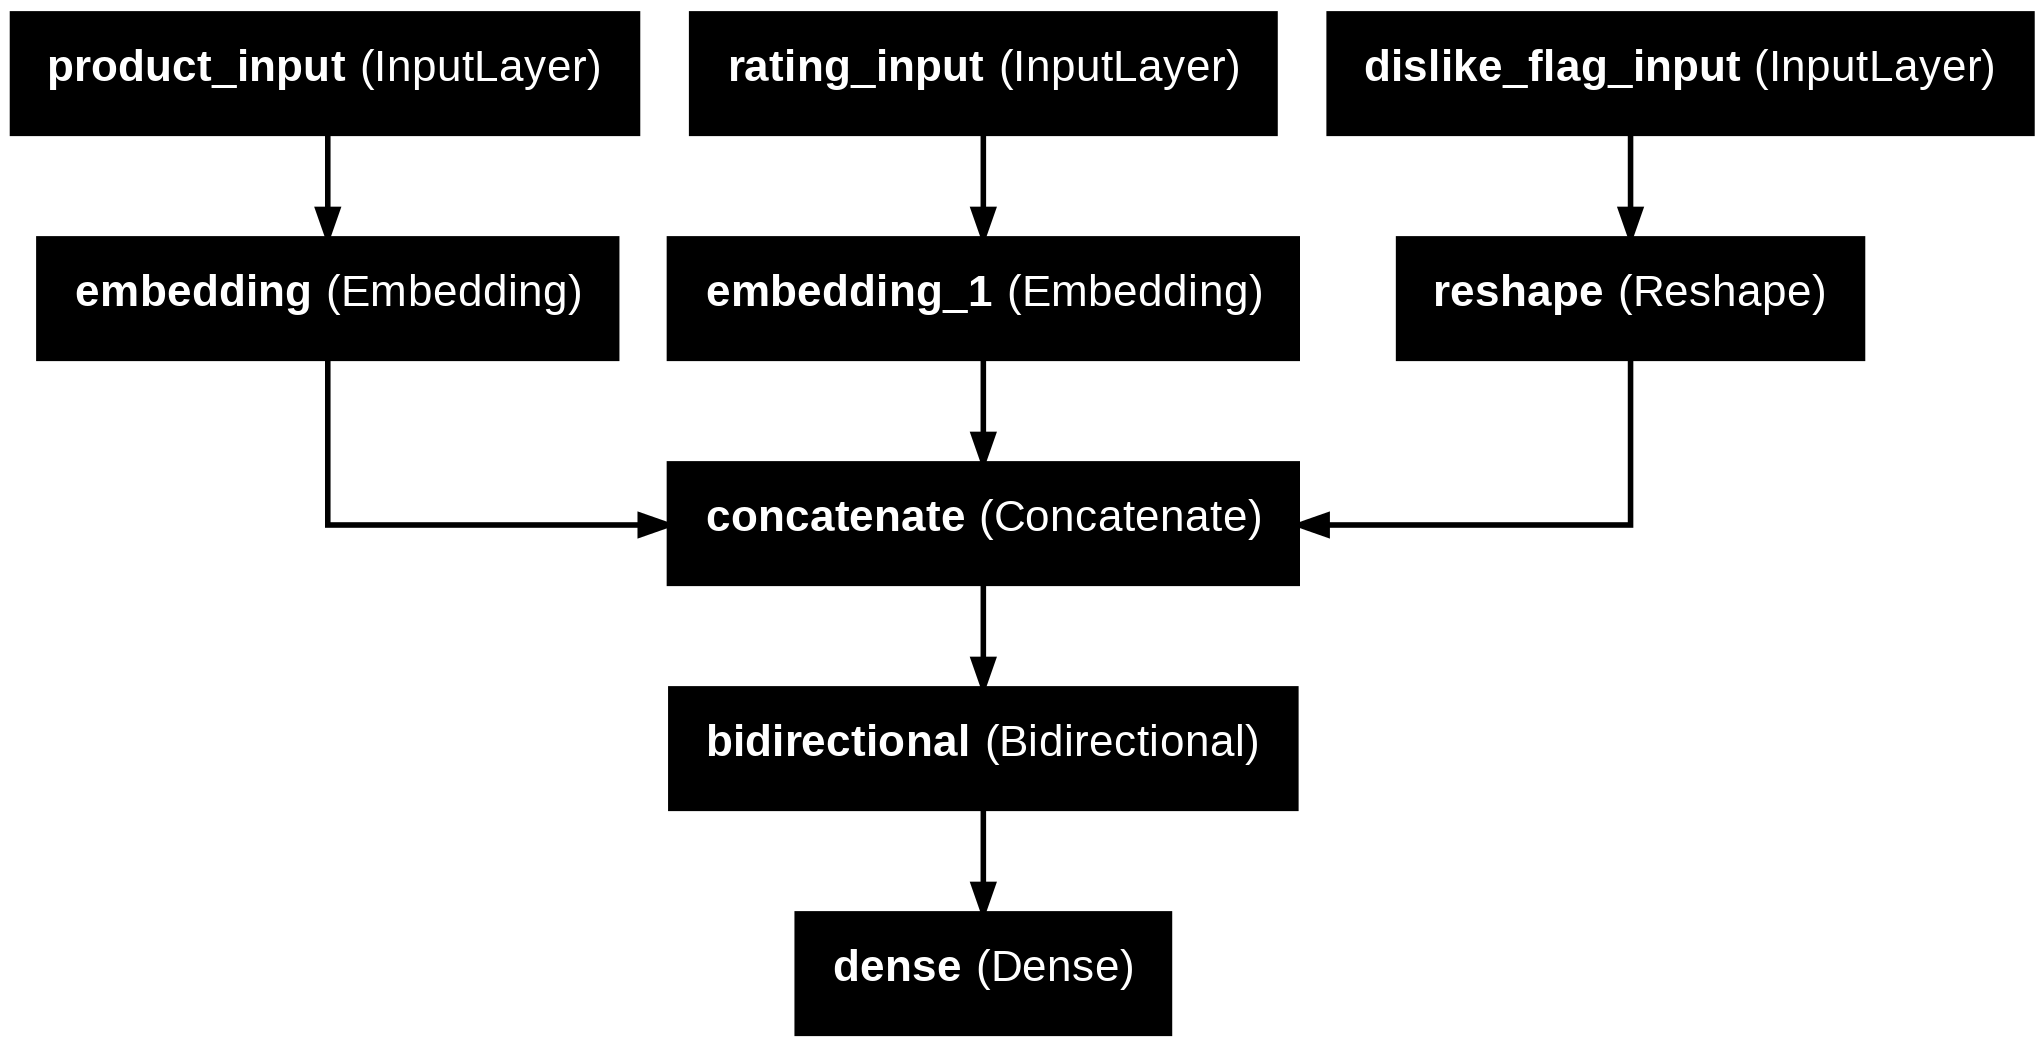

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_lstm1, to_file='plot.png', show_layer_names=True)

In [ ]:
history_lstm1 = model_lstm1.fit(
    [product_ids, ratings, dislike_flags],
    yratings_array,
    validation_split=0.2,
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 79s 14ms/step - loss: 3.4411 - masked_mae: 1.2776 - masked_rmse: 1.5895 - val_loss: 1.0699 - val_masked_mae: 0.7547 - val_masked_rmse: 1.0295
Epoch 2/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - loss: 1.0026 - masked_mae: 0.7265 - masked_rmse: 0.9962 - val_loss: 0.9445 - val_masked_mae: 0.6951 - val_masked_rmse: 0.9664
Epoch 3/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 75s 13ms/step - loss: 0.8326 - masked_mae: 0.6501 - masked_rmse: 0.9075 - val_loss: 0.8675 - val_masked_mae: 0.6517 - val_masked_rmse: 0.9253
Epoch 4/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - loss: 0.6998 - masked_mae: 0.5840 - masked_rmse: 0.8310 - val_loss: 0.8013 - val_masked_mae: 0.6169 - val_masked_rmse: 0.8883
Epoch 5/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - loss: 0.5818 - masked_mae: 0.5250 - masked_rmse: 0.7567 - val_loss: 0.7683 - val_masked_mae: 0.5940 - val_masked_rmse: 0.8687
Epoch 6/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 63s 12ms/step - loss: 0.4890 - masked_

In [ ]:
import matplotlib.pyplot as plt

def plot_model_history(history):
    """
    Plots the training and validation metrics (loss, MAE, and RMSE) from a model's history object.

    Parameters:
    - history: The history object from model.fit() containing training and validation metrics.

    Returns:
    - None. Displays the plots.
    """
    # Plot training & validation loss values
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation MAE values
    plt.figure(figsize=(10, 5))
    if 'masked_mae' in history.history and 'val_masked_mae' in history.history:
        plt.plot(history.history['masked_mae'], label='Train')
        plt.plot(history.history['val_masked_mae'], label='Validation')
        plt.title('Model MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.show()
    else:
        print("MAE metrics not found in the history.")

    # Plot training & validation RMSE values
    plt.figure(figsize=(10, 5))
    if 'masked_rmse' in history.history and 'val_masked_rmse' in history.history:
        plt.plot(history.history['masked_rmse'], label='Train')
        plt.plot(history.history['val_masked_rmse'], label='Validation')
        plt.title('Model RMSE')
        plt.ylabel('RMSE')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.show()
    else:
        print("RMSE metrics not found in the history.")


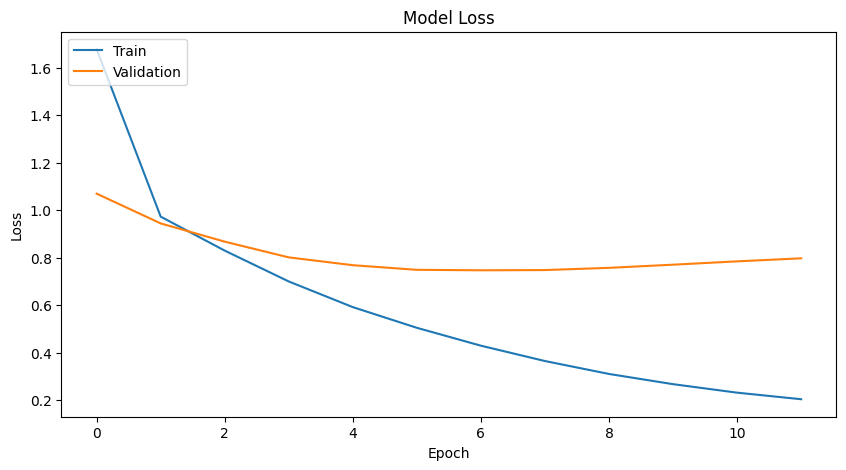

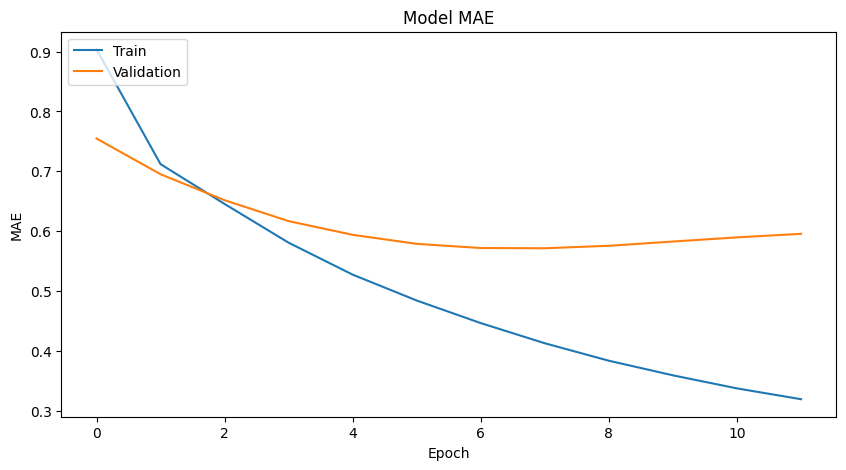

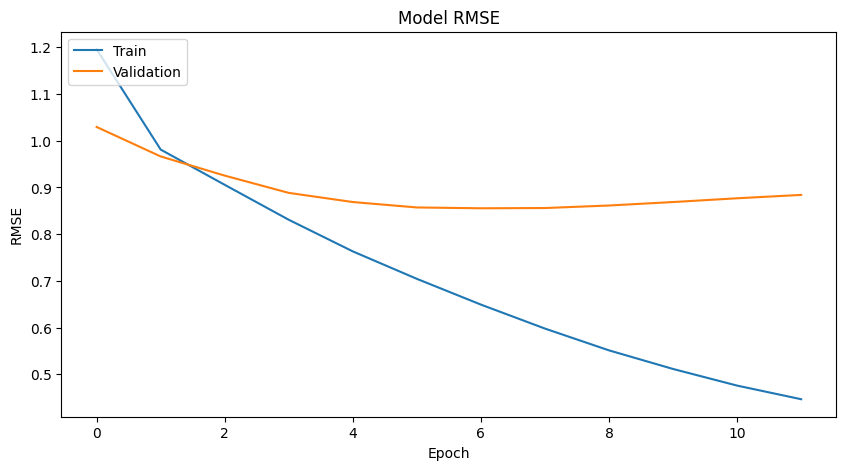

In [ ]:
plot_model_history(history_lstm1)

In [ ]:
k = len(product_ids)
interaction_matrix_test, yratings_array_test, dislike_flags_array_test = create_interaction_array_with_dislike_flag(test_df, k)

Processing users: 100%|██████████| 491084/491084 [00:52<00:00, 9320.80it/s]


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def test_model(model, interaction_matrix_test, yratings_array_test, dislike_flags_array_test):
    """
    Evaluates the model performance on the test set using RMSE and MAE, masking out zero values in true ratings.

    Parameters:
    - model: The trained Keras model.
    - interaction_matrix_test: Test set interaction matrix (shape: (num_samples, sequence_length, 2)).
    - yratings_array_test: True ratings for the test set (shape: (num_samples, num_products)).
    - dislike_flags_array_test: Dislike flags for the test set (shape: (num_samples, sequence_length)).

    """
    product_ids_test = interaction_matrix_test[:, :, 0]
    ratings_test = interaction_matrix_test[:, :, 1]
    dislike_flags_test = dislike_flags_array_test

    y_pred = model.predict([product_ids_test, ratings_test, dislike_flags_test])

    mask = yratings_array_test != 0
    y_true_masked = yratings_array_test[mask]
    y_pred_masked = y_pred[mask]

    rmse = np.sqrt(mean_squared_error(y_true_masked, y_pred_masked))

    mae = mean_absolute_error(y_true_masked, y_pred_masked)

    print(f"Test RMSE (masked): {rmse}")
    print(f"Test MAE (masked): {mae}")


In [ ]:
test_model(model_lstm1, interaction_matrix_test, yratings_array_test, dislike_flags_array_test)

1582/1582 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Test RMSE (masked): 0.86692214012146
Test MAE (masked): 0.5756526589393616


In [ ]:
model_lstm1.save('/content/drive/MyDrive/Model/model_lstm1.keras')

# LSTM 2

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, SimpleRNN, LSTM, Dense, Dropout, BatchNormalization,
    Embedding, Concatenate, Reshape
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

seqlen = 3
embedding_dim = 92
num_products = k

# Input layers
product_input = Input(shape=(seqlen,), name="input_product")
dislike_flag_input = Input(shape=(seqlen,), name="input_dislike_flag")
rating_input = Input(shape=(seqlen,), name="input_ratings")

# Embedding layer for product indices
embedding_layer = Embedding(
    input_dim=num_products, output_dim=embedding_dim, input_length=seqlen, name="product_embedding"
)
product_embeddings = embedding_layer(product_input)  # Embed product indices

# Combine product embeddings and ratings
ratings_reshaped = Reshape((seqlen, 1))(rating_input)
combined_features = Concatenate(axis=-1)([product_embeddings, ratings_reshaped])

# Conv1D layer to capture local patterns in combined features
conv_layer = Conv1D(filters=64, kernel_size=2, activation='relu', padding='same')(combined_features)

# SimpleRNN layer to capture sequential dependencies
rnn_layer = SimpleRNN(64, activation='relu', return_sequences=True)(conv_layer)

dislike_flag_reshaped = Reshape((seqlen, 1))(dislike_flag_input)  # Use 'seqlen' directly since it matches input shape
concat_features = Concatenate(axis=-1)([rnn_layer, dislike_flag_reshaped])

# LSTM to process concatenated features
lstm_layer = LSTM(64, activation='relu')(concat_features)

# Fully connected layers
dense_hidden = Dense(128, activation='relu')(lstm_layer)
dropout_layer = Dropout(0.5)(dense_hidden)
bn_layer = BatchNormalization()(dropout_layer)

# Output layer for multi-step rating prediction
rating_output = Dense(num_products, activation='linear', name='rating_output')(bn_layer)

model_lstm2 = Model(inputs=[product_input, dislike_flag_input, rating_input], outputs=[rating_output])

model_lstm2.compile(
    optimizer=RMSprop(learning_rate=0.0005),
    loss=masked_mse,
    metrics=[masked_mae, masked_rmse]
)

model_lstm2.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_product             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ratings             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ product_embedding         │ (None, 3, 92)          │        687,608 │ input_product[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 3, 1)           │              0 │ input_ratings[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 3, 93)          │              0 │ product_embedding[0][… │
│ (Concatenate)             │                        │                │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 3, 64)          │         11,968 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_dislike_flag        │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn_1 (SimpleRNN)  │ (None, 3, 64)          │          8,256 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 3, 1)           │              0 │ input_dislike_flag[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 3, 65)          │              0 │ simple_rnn_1[0][0],    │
│ (Concatenate)             │                        │                │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 64)             │         33,280 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │          8,320 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 128)            │            512 │ dropout_4[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rating_output (Dense)     │ (None, 7474)           │        964,146 │ batch_normalization_4… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,714,090 (6.54 MB)

 Trainable params: 1,713,834 (6.54 MB)

 Non-trainable params: 256 (1.00 KB)

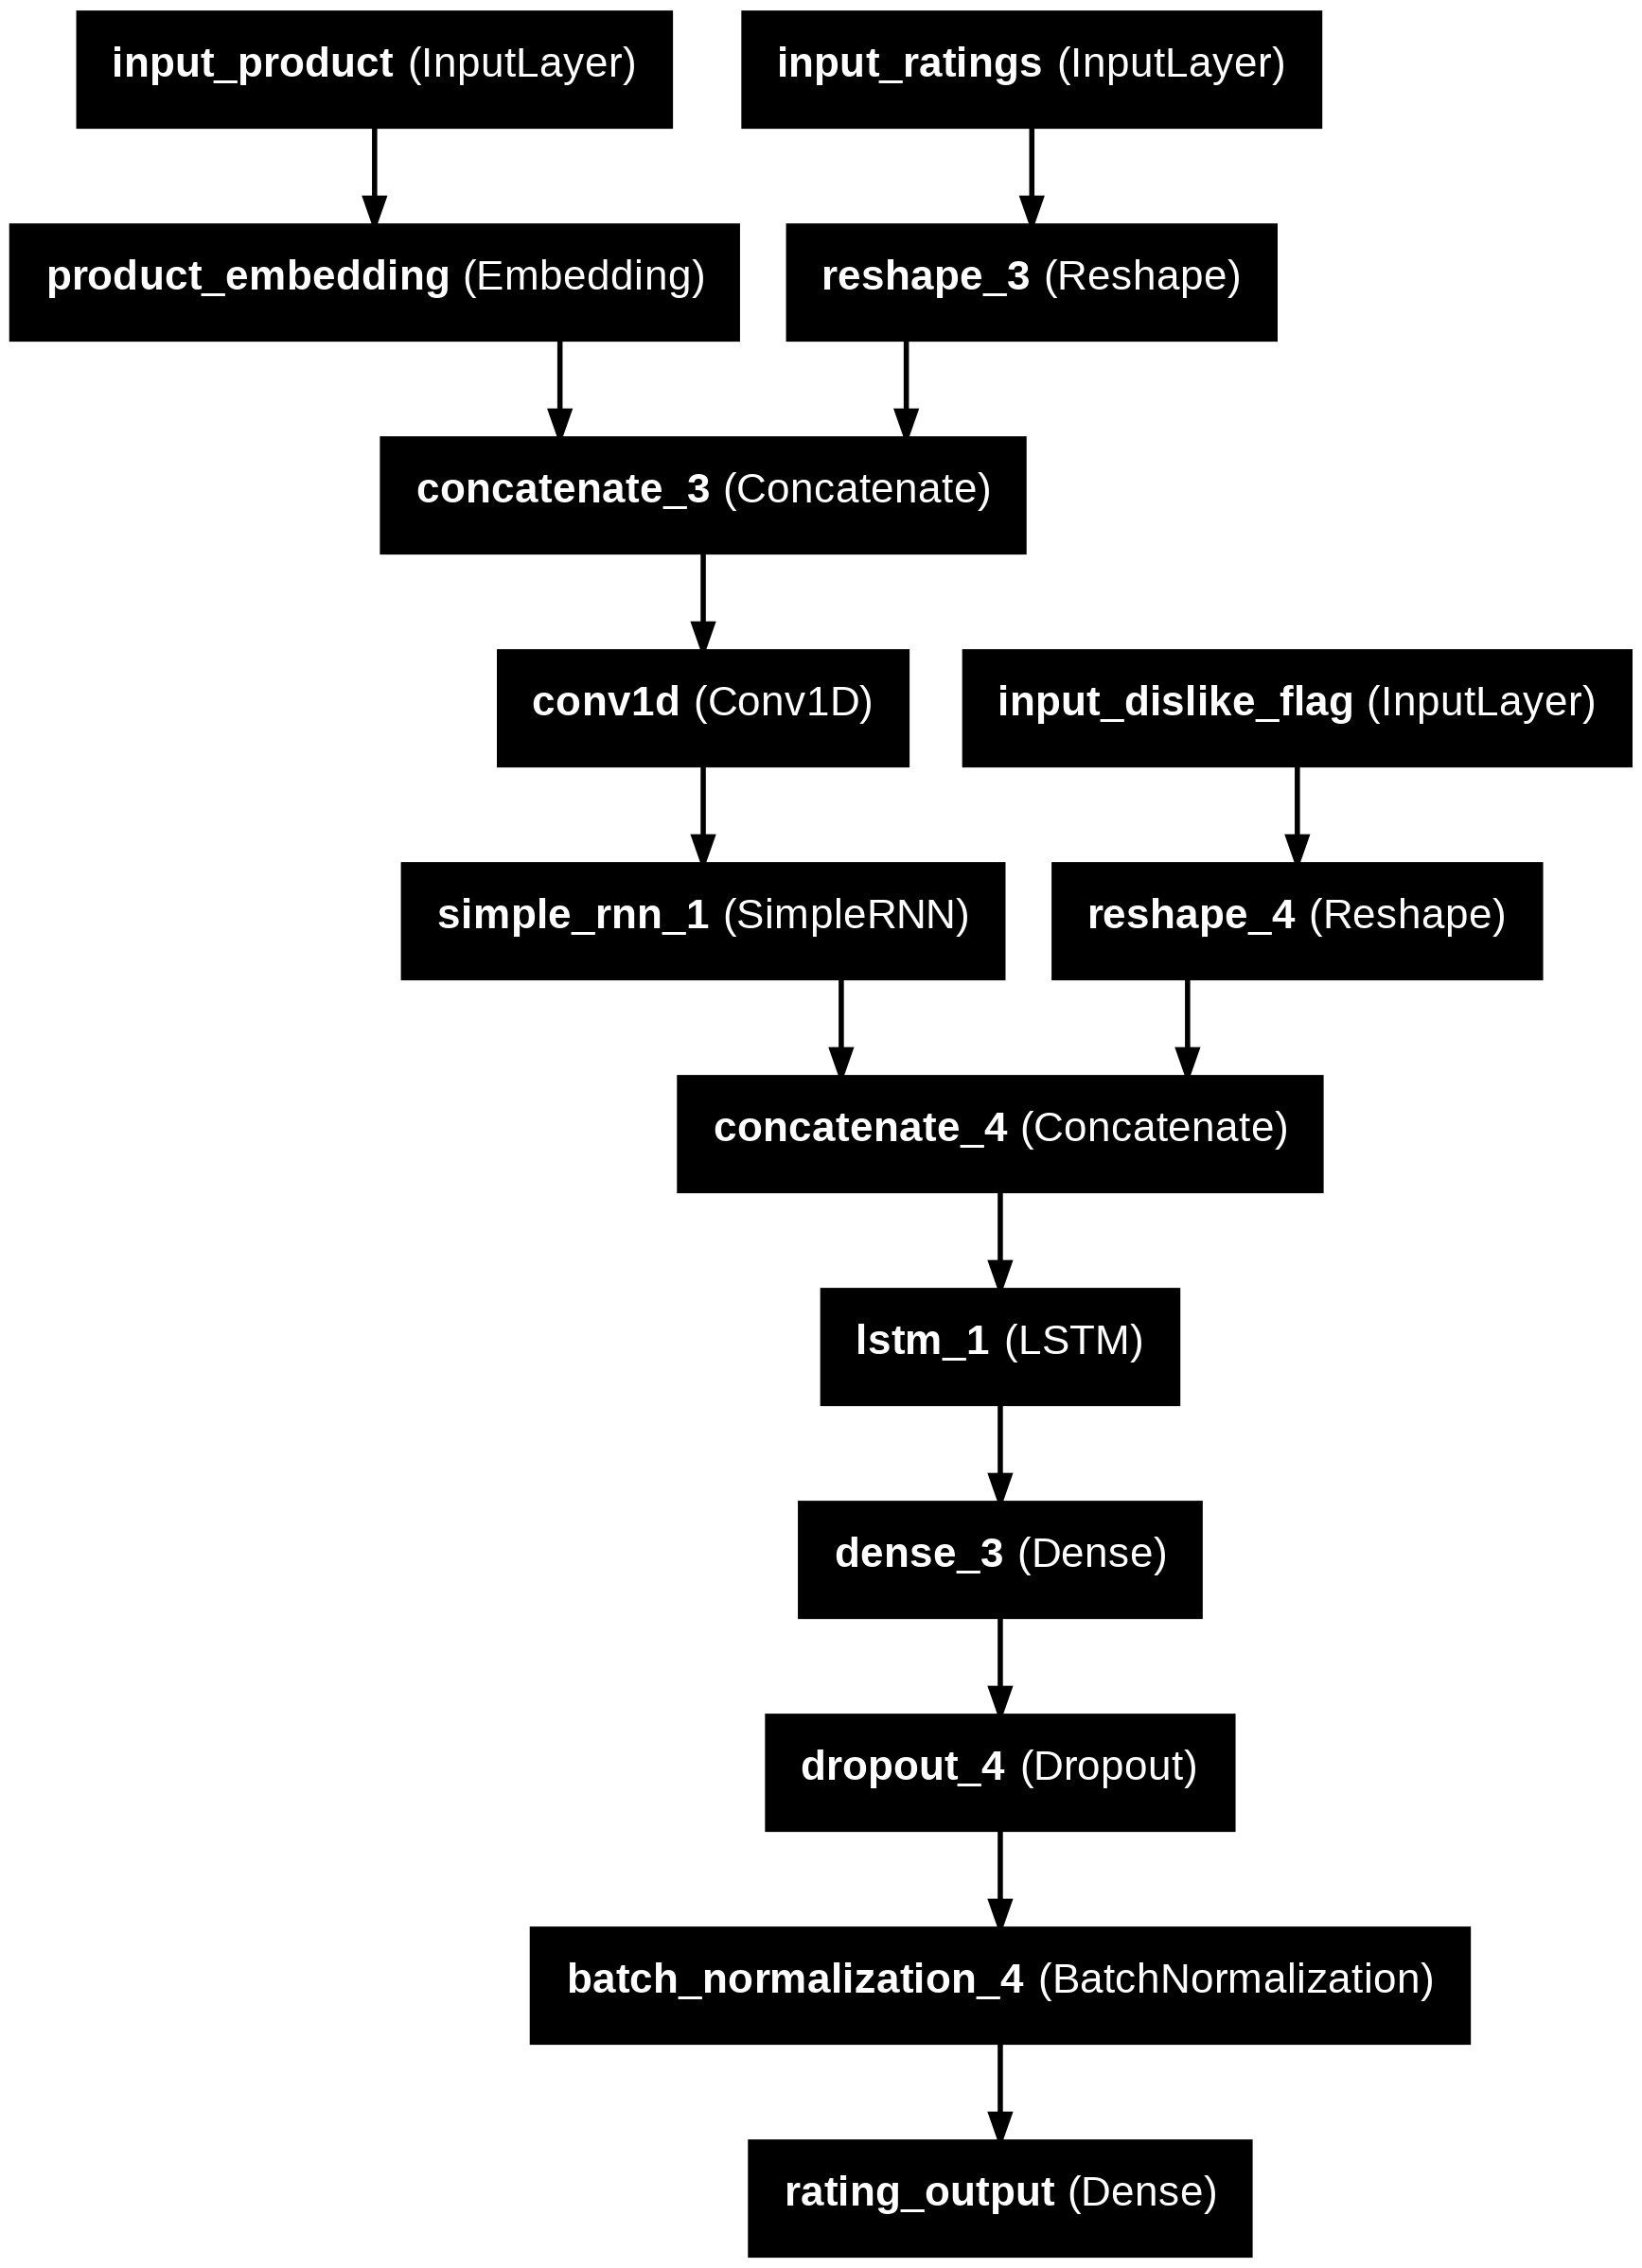

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_lstm2, to_file='plot.png', show_layer_names=True)

In [ ]:
history_lstm2 = model_lstm2.fit(
    [product_ids, ratings, dislike_flags],
    yratings_array,
    validation_split=0.2,
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 9.7858 - masked_mae: 2.5718 - masked_rmse: 2.8709 - val_loss: 1.0168 - val_masked_mae: 0.7067 - val_masked_rmse: 1.0028
Epoch 2/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.9812 - masked_mae: 0.7038 - masked_rmse: 0.9848 - val_loss: 0.9182 - val_masked_mae: 0.7056 - val_masked_rmse: 0.9526
Epoch 3/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.9046 - masked_mae: 0.6703 - masked_rmse: 0.9456 - val_loss: 0.9035 - val_masked_mae: 0.6456 - val_masked_rmse: 0.9440
Epoch 4/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.8728 - masked_mae: 0.6540 - masked_rmse: 0.9283 - val_loss: 0.8611 - val_masked_mae: 0.6538 - val_masked_rmse: 0.9212
Epoch 5/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.8532 - masked_mae: 0.6455 - masked_rmse: 0.9176 - val_loss: 0.8402 - val_masked_mae: 0.6628 - val_masked_rmse: 0.9105
Epoch 6/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.8446 - masked_mae: 0

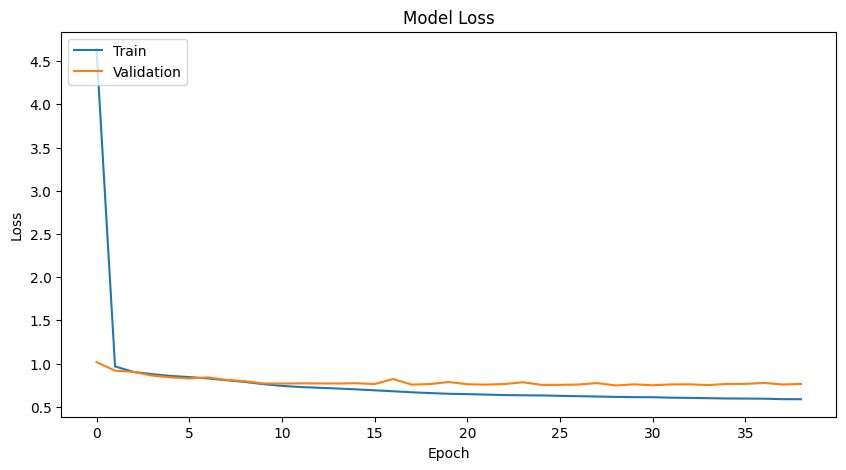

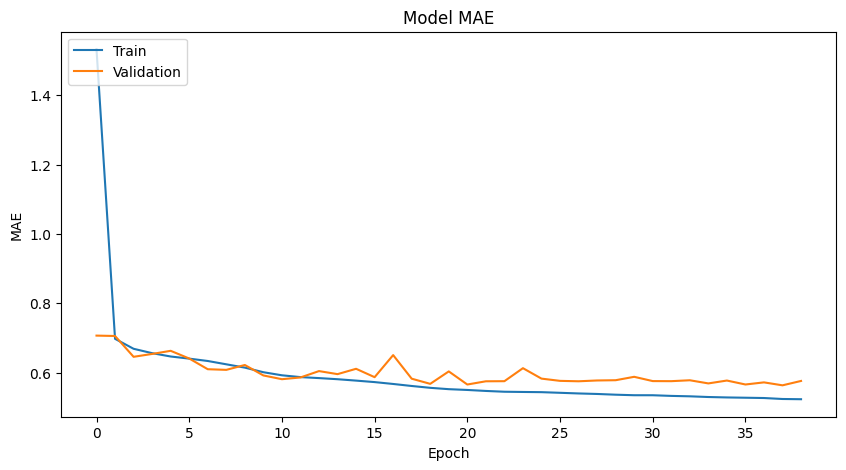

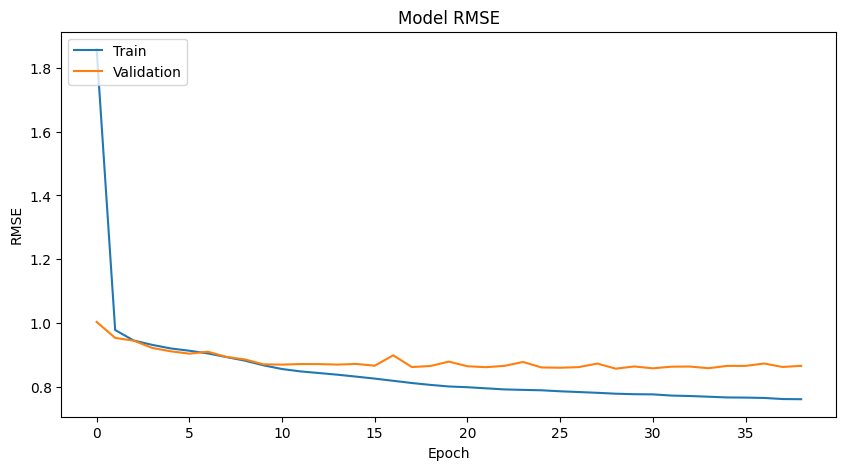

In [ ]:
plot_model_history(history_lstm2)

In [ ]:
test_model(model_lstm2, interaction_matrix_test, yratings_array_test, dislike_flags_array_test)

1582/1582 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Test RMSE (masked): 0.8632164001464844
Test MAE (masked): 0.579578161239624


In [ ]:
model_lstm2.save('/content/drive/MyDrive/Model/model_lstm2.keras')

# Simple RNN

In [ ]:

# Define model inputs
product_input = layers.Input(shape=(3,), name="product_input", dtype=tf.int32)
rating_input = layers.Input(shape=(3,), name="rating_input", dtype=tf.float32)
dislike_flag_input = layers.Input(shape=(3,), name="dislike_flag_input", dtype=tf.float32)

# Embedding layers
product_embedding = layers.Embedding(input_dim=len(product_ids), output_dim=50)(product_input)
rating_embedding = layers.Embedding(input_dim=6, output_dim=1)(rating_input)
dislike_flag_input_expanded = layers.Reshape((3, 1))(dislike_flag_input)

# Combine embeddings and flags
merged_input = layers.Concatenate(axis=-1)([product_embedding, rating_embedding, dislike_flag_input_expanded])

merged_input = layers.BatchNormalization()(merged_input)
merged_input = layers.Dropout(0.6)(merged_input)

rnn_output = layers.Bidirectional(layers.SimpleRNN(64, return_sequences=False))(merged_input)
rnn_output = layers.BatchNormalization()(rnn_output)
rnn_output = layers.Dropout(0.6)(rnn_output)

dense_output = layers.Dense(k, activation='linear')(rnn_output)

modelrnn = models.Model(inputs=[product_input, rating_input, dislike_flag_input], outputs=dense_output)

modelrnn.compile(optimizer='adam', loss=masked_mse, metrics=[masked_mae, masked_rmse])

modelrnn.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ product_input             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rating_input (InputLayer) │ (None, 3)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dislike_flag_input        │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 3, 50)          │     10,150,250 │ product_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 3, 1)           │              6 │ rating_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 3, 1)           │              0 │ dislike_flag_input[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 3, 52)          │              0 │ embedding_2[0][0],     │
│ (Concatenate)             │                        │                │ embedding_3[0][0],     │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 3, 52)          │            208 │ concatenate_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 3, 52)          │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 128)            │         14,976 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128)            │            512 │ bidirectional_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 7474)           │        964,146 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,130,098 (42.46 MB)

 Trainable params: 11,129,738 (42.46 MB)

 Non-trainable params: 360 (1.41 KB)

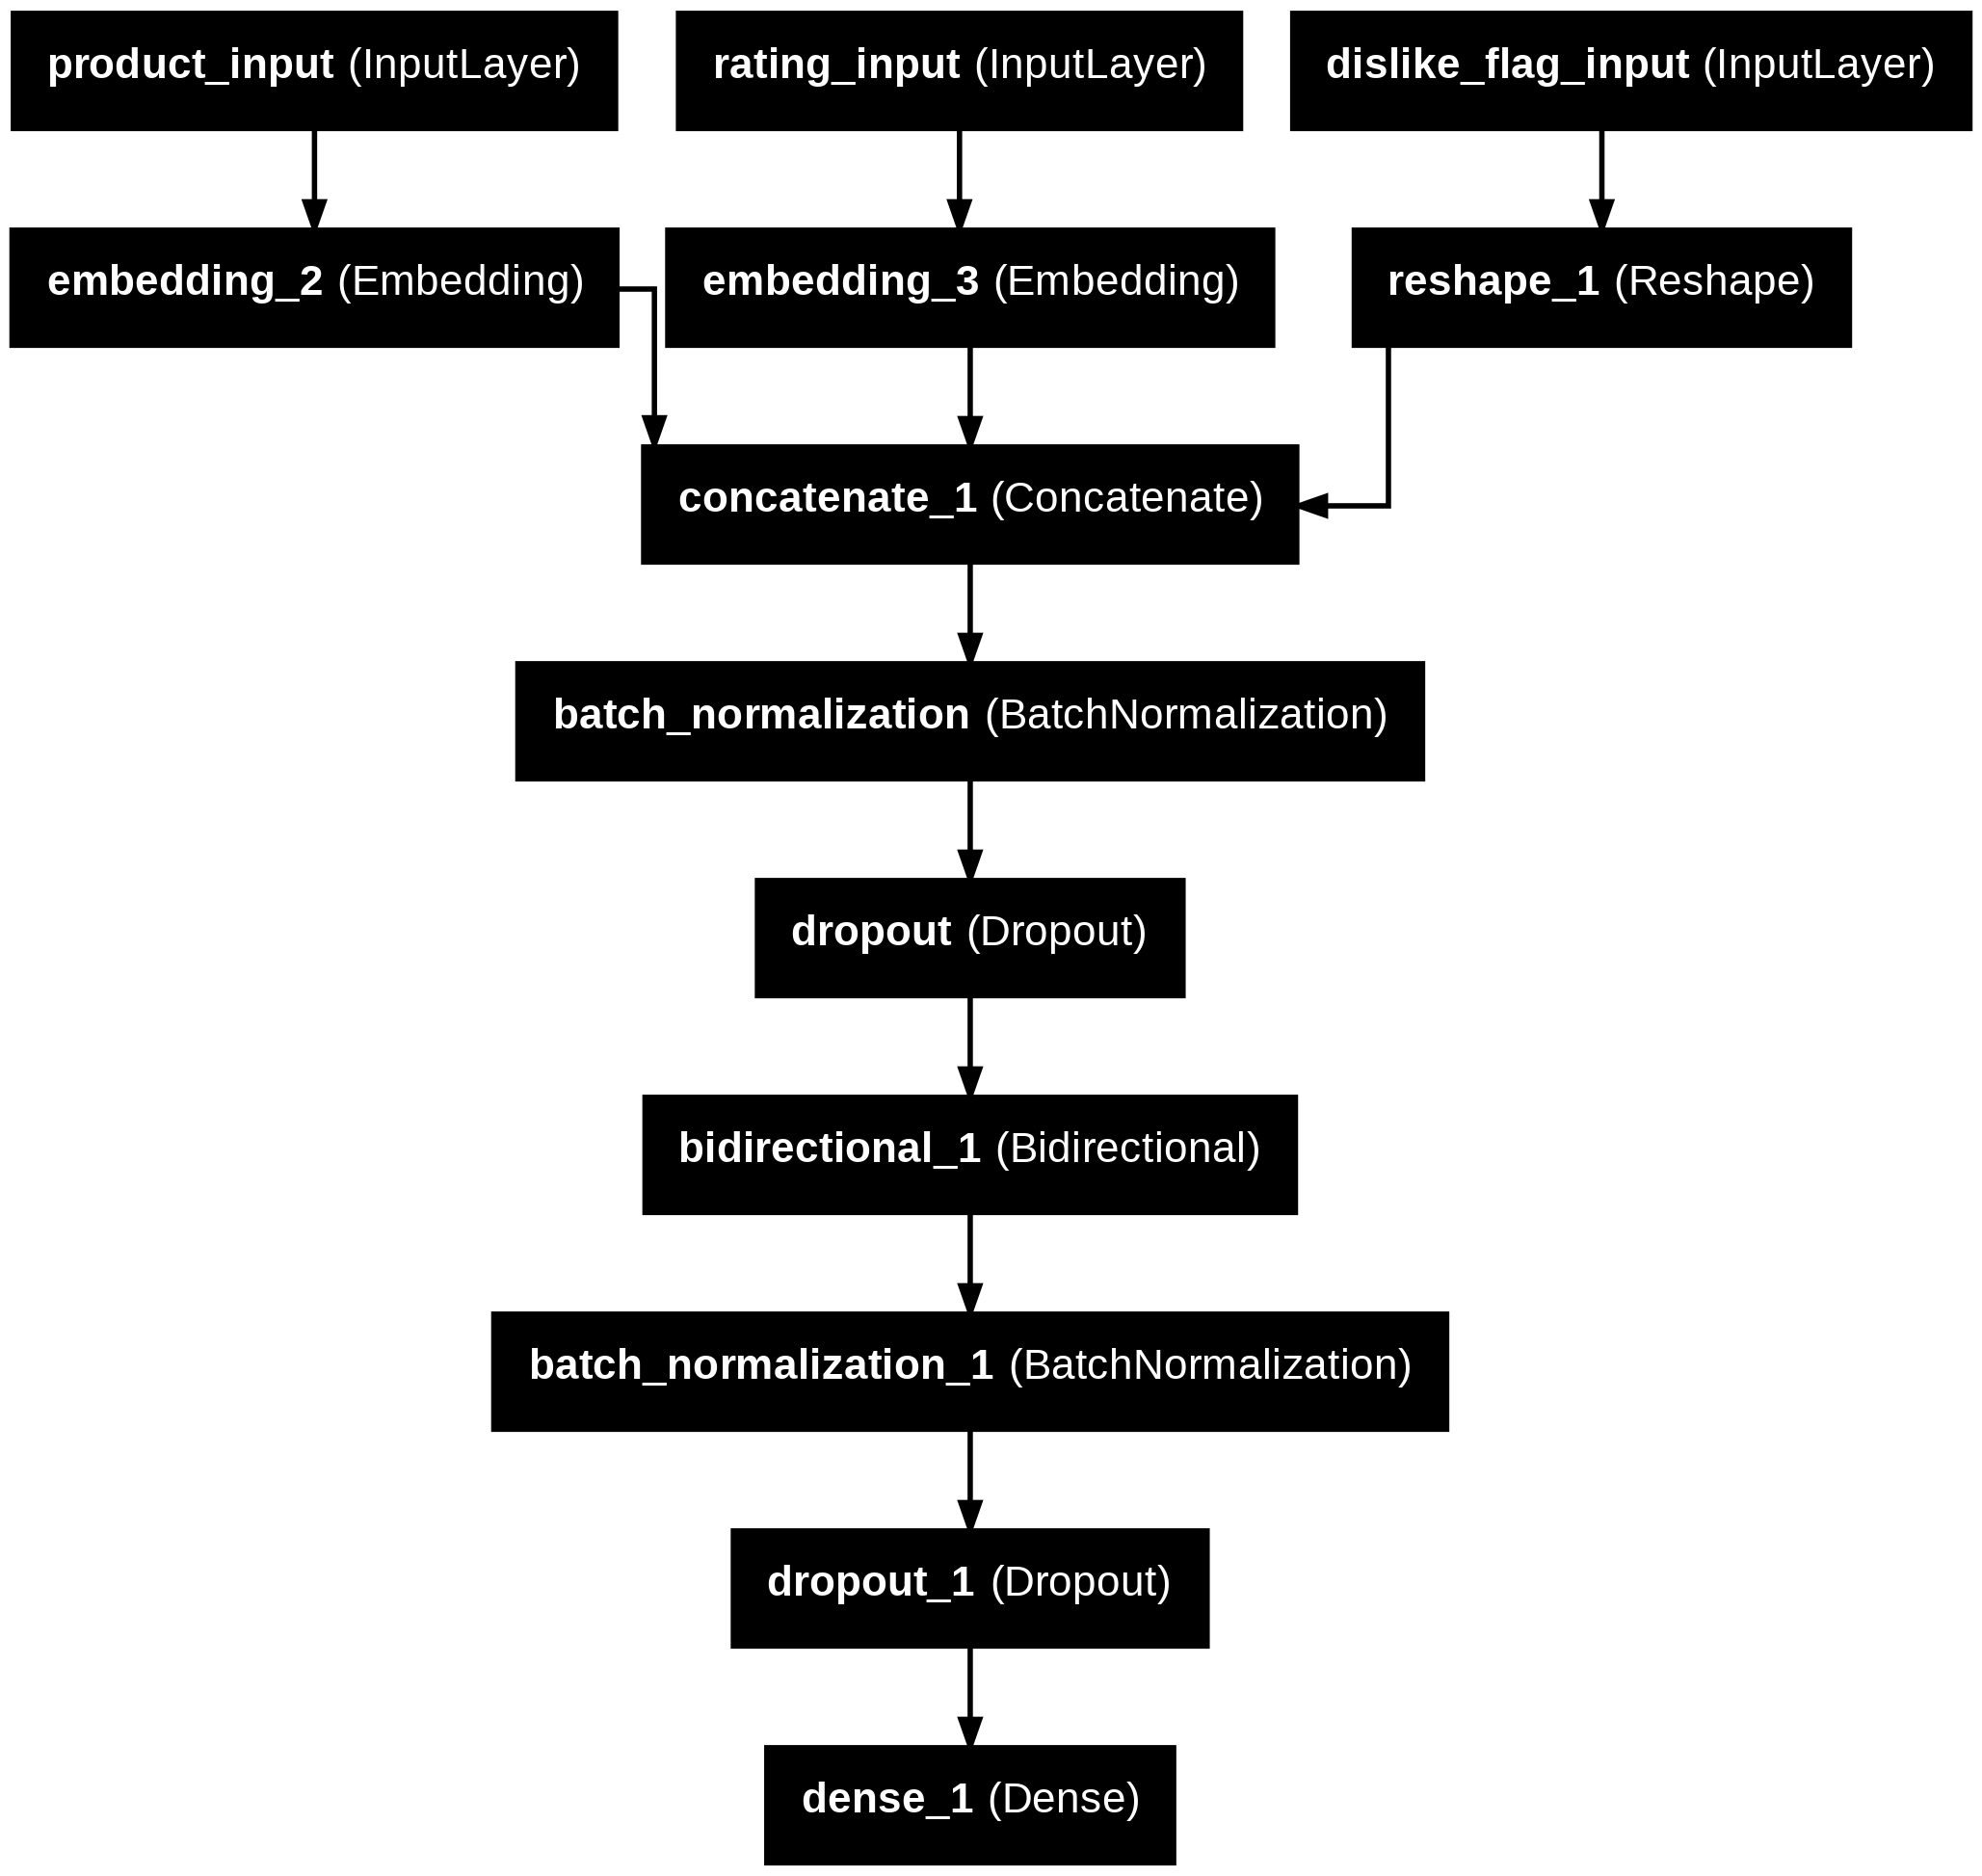

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(modelrnn, to_file='plot.png', show_layer_names=True)

In [ ]:
history_rnn = modelrnn.fit(
    [product_ids, ratings, dislike_flags],
    yratings_array,
    validation_split=0.2,
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping]  )

Epoch 1/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 9.8055 - masked_mae: 2.6007 - masked_rmse: 2.8742 - val_loss: 1.1767 - val_masked_mae: 0.8213 - val_masked_rmse: 1.0808
Epoch 2/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 1.6399 - masked_mae: 1.0026 - masked_rmse: 1.2765 - val_loss: 1.1128 - val_masked_mae: 0.7914 - val_masked_rmse: 1.0506
Epoch 3/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 1.4915 - masked_mae: 0.9481 - masked_rmse: 1.2172 - val_loss: 1.0595 - val_masked_mae: 0.7698 - val_masked_rmse: 1.0248
Epoch 4/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 1.4157 - masked_mae: 0.9175 - masked_rmse: 1.1856 - val_loss: 1.0346 - val_masked_mae: 0.7495 - val_masked_rmse: 1.0124
Epoch 5/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 1.3647 - masked_mae: 0.8981 - masked_rmse: 1.1640 - val_loss: 1.0276 - val_masked_mae: 0.7501 - val_masked_rmse: 1.0090
Epoch 6/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 1.3379 - masked_mae: 0

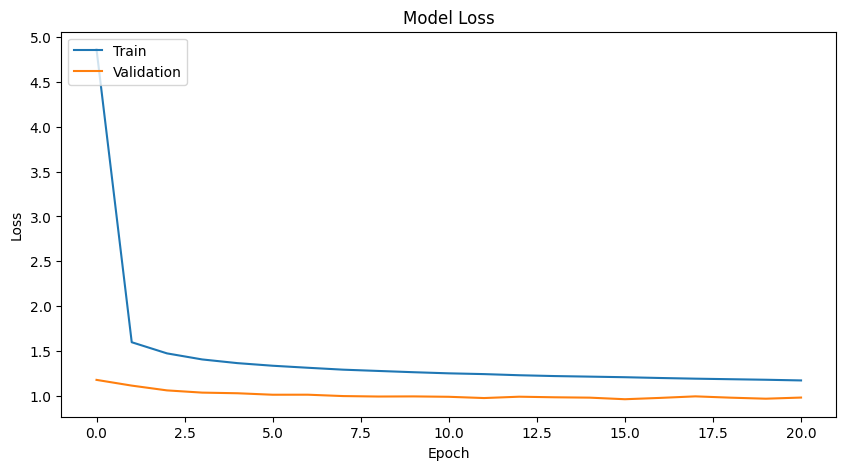

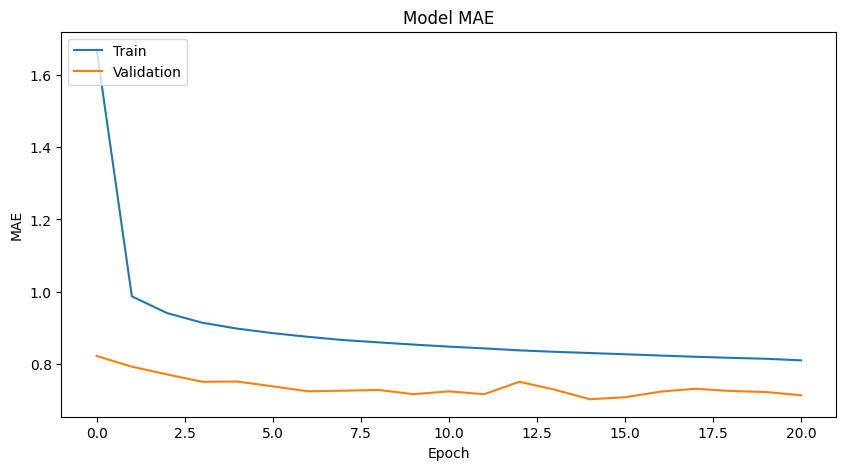

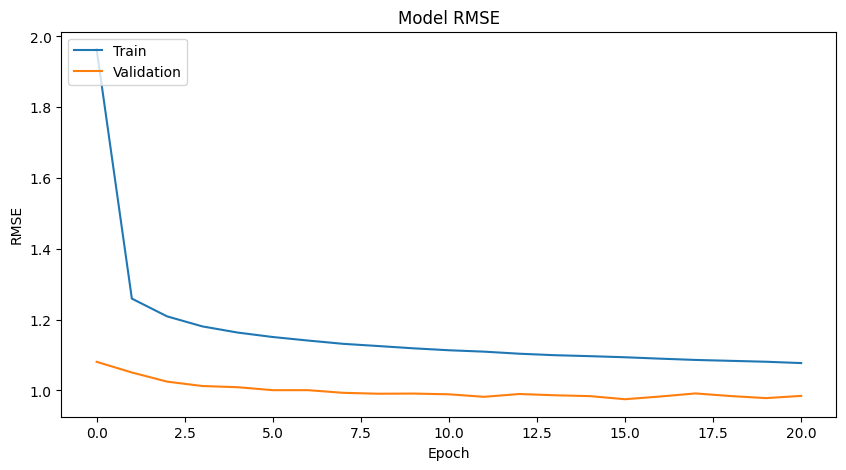

In [ ]:
plot_model_history(history_rnn)

In [ ]:
test_model(modelrnn, interaction_matrix_test, yratings_array_test, dislike_flags_array_test)

1582/1582 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Test RMSE (masked): 0.9754050374031067
Test MAE (masked): 0.7041741609573364


In [ ]:
modelrnn.save('/content/drive/MyDrive/Model/modelrnn.keras')